<h3 style="color: #2E86C1; text-decoration: underline;">Contexte du problème</h3>

Ce challenge porte sur la prédiction des rendements des actions, sur un marché boursier. Étant donné un ensemble de $ N $ actions et leurs rendements $ R_t $ à un instant $ t $, l'objectif est de concevoir à chaque instant $ t $ un vecteur $ S_{t+1} $ qui maximisera le chevauchement avec les rendements réels $ R_{t+1} $, c'est-à-dire $ \langle S_{t+1}, R_{t+1} \rangle $. Ce problème est abordé avec un modèle factoriel linéaire, où les facteurs sont appris dans un espace de paramètres non linéaire.


<h3 style="color: #2E86C1; text-decoration: underline;">Vue d'ensemble du modèle</h3>

Le modèle classique utilisé pour prédire les rendements des actions est un modèle linéaire :

$$
S_{t+1} = \sum_{\ell=1}^F \beta_\ell F_{t,\ell}
$$

Où :

- $ F_{t,\ell} $ sont des facteurs explicatifs ou des caractéristiques.
- $ \beta_1, \dots, \beta_F $ sont les paramètres du modèle qui sont appris lors de l'entraînement.

Le challenge explore également la possibilité de concevoir les facteurs eux-mêmes, où $ F_{t,\ell} $ sont des fonctions linéaires des rendements passés. Cela conduit à la formulation suivante :

$$
F_{t,\ell} = \sum_{k=1}^D A_{k\ell} R_{t+1-k}
$$

Ici :

- $ A_\ell $ sont des vecteurs qui définissent les facteurs, et
- $ D $ est la profondeur temporelle.

Les vecteurs $ A_1, \dots, A_F $ doivent être orthonormés, ce qui ajoute une contrainte non linéaire à l'espace des paramètres.

<h3 style="color: #2E86C1; text-decoration: underline;">Objectif</h3>

L'objectif est de concevoir et d'apprendre les facteurs $ F_{t,\ell} $ pour la prédiction des rendements des actions, tout en garantissant que les vecteurs $ A_1, \dots, A_F $ respectent la contrainte d'orthonormalité.

<h3 style="color: #2E86C1; text-decoration: underline;">Données</h3>

- **Données d'entraînement** : Un dataframe contenant les rendements quotidiens de 50 actions sur une période de 754 jours (3 ans) est fourni. Ces données seront utilisées pour apprendre les paramètres $ A $ et $ \beta $.
- **Données de test** : Un jeu de données de test est fourni, comportant les jours de rendements suivants les 250 jours des données d'entraînement.

<h3 style="color: #2E86C1; text-decoration: underline;">Sortie attendue</h3>

La sortie attendue des participants est un vecteur contenant les paramètres :

- Une matrice $ A $ de taille $ 250 \times 10 $, représentant les vecteurs de facteurs appris.
- Un vecteur $ \beta $ de taille $ 10 $, représentant les paramètres du modèle.

Ces sorties doivent être empilées dans un seul vecteur de taille $ 2510 $.

<h3 style="color: #2E86C1; text-decoration: underline;">Métrique d'évaluation</h3>

La performance du modèle est évaluée par une métrique qui mesure l'alignement entre les rendements prédits et les rendements réels pour les données de test, définie comme suit :

$$
M_{\text{trique}}(A, \beta) = \frac{1}{504} \sum_{t=250}^{753} \frac{\langle S_t, R_t \rangle}{\|S_t\| \|R_t\|}
$$

Si la condition d'orthonormalité $ \langle A_i, A_j \rangle = \delta_{ij} $ est violée, la métrique renverra -1. Sinon, la métrique variera entre -1 et 1.

<h3 style="color: #2E86C1; text-decoration: underline;">Stratégie de benchmarking</h3>

Une approche de base est fourni consistant à générer des vecteurs orthonormés aléatoires $ A_1, \dots, A_F $, à ajuster $ \beta $ par régression linéaire sur les données d'entraînement et à sélectionner le meilleur résultat en fonction de la métrique. La procédure de benchmark est la suivante :

1. Générer aléatoirement $ A_1, \dots, A_F $.
2. Appliquer l'algorithme de Gram-Schmidt pour garantir l'orthonormalité.
3. Ajuster $ \beta $ en utilisant la régression des moindres carrés.
4. Calculer la métrique et sélectionner le meilleur modèle.

Cela fournit une stratégie de référence pour comparer les solutions modélisées.

<h3 style="color: #2E86C1; text-decoration: underline;">Méthodologie</h3>

Dans un premier temps, nous allons définir des features classiques des facteurs de rendement connus dans la littérature, telles que :

Ensuite, à partir de ces features, nous réaliserons un premier modèle linéaire simple afin d'obtenir une valeur de la métrique d'égalité du modèle.

Nous obtiendrons ensuite un modèle non supervisé grâce à une ACP afin d'en extraire les facteurs explicatifs des rendements et d'observer les performances de ce modèle par rapport au modèle simple.

Nous effectuerons également un modèle supervisé (on verra lequel).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
# Chargement des données
path = '/Users/kemache/Library/CloudStorage/OneDrive-UniversitéParis-Dauphine/Bureau/Etudes/Master 2 Econome et Ingénierie financière/Machine Learning/Projet/' 
#ton path = 'C:/Users/theod/OneDrive/Bureau/Theo/Master IEF Dauphine/S2/Machine Learning/Projet/' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

# Affichage des premières lignes des datasets
print("Aperçu des données X_train:")
print(X_train.head())
print("\nAperçu des données Y_train:")
print(Y_train.head())


Aperçu des données X_train:
date             0         1         2         3         4         5  \
stocksID                                                               
0        -0.018647 -0.013002 -0.010776 -0.016676 -0.005110  0.009092   
1        -0.008254 -0.022280  0.012173 -0.006820 -0.004055  0.012912   
2        -0.008404 -0.013629 -0.006044 -0.003425 -0.009522 -0.001353   
3        -0.022734 -0.006981 -0.008568 -0.010899 -0.017981  0.002485   
4        -0.024546 -0.008315 -0.007991 -0.003515  0.007872  0.007082   

date             6         7         8         9  ...       744       745  \
stocksID                                          ...                       
0        -0.011745  0.007120 -0.008451  0.009119  ... -0.012525 -0.011716   
1        -0.001293  0.009994 -0.002747  0.001664  ...  0.014432 -0.002255   
2        -0.000637  0.007640  0.001600  0.007416  ... -0.006245 -0.001329   
3        -0.011980  0.012446 -0.010636  0.003807  ... -0.005179 -0.003442   
4    

In [4]:

# Vérification des valeurs manquantes par actif (ligne)
missing_values_per_stock = X_train.isnull().sum(axis=1)
missing_values_per_stock = missing_values_per_stock[missing_values_per_stock > 0]

if not missing_values_per_stock.empty:
    plt.figure(figsize=(10, 5))
    missing_values_per_stock.plot(kind="bar")
    plt.xlabel("Index des stocks")
    plt.ylabel("Nombre de valeurs manquantes")
    plt.title("Valeurs manquantes par actif")
    plt.show()
else:
    print("Aucune valeur manquante détectée dans X_train.")

print("Nombre de valeurs manquantes par actif:")
print(missing_values_per_stock)

# Remplacement des valeurs manquantes par la moyenne de chaque ligne
X_train = X_train.apply(lambda row: row.fillna(row.mean()), axis=1)

# Vérification après imputation
total_missing_after = X_train.isnull().sum().sum()
print(f"Total de valeurs manquantes après imputation : {total_missing_after}")





Aucune valeur manquante détectée dans X_train.
Nombre de valeurs manquantes par actif:
Series([], dtype: int64)
Total de valeurs manquantes après imputation : 0


## Analyse statistiques des données


Statistiques des actifs:
                  Mean       Std  Skewness  Kurtosis       Max       Min
stocksID                                                                
0         1.565039e-04  0.011626  0.373388  1.702471  0.059061 -0.042102
1         3.313147e-04  0.006856 -0.263619  1.613290  0.021139 -0.033115
2        -3.476568e-04  0.009378 -0.034502  0.976077  0.036398 -0.033386
3        -1.999018e-07  0.011018 -0.147188  0.981895  0.046312 -0.045707
4         1.057414e-04  0.011078 -0.132906  2.053168  0.056822 -0.046940


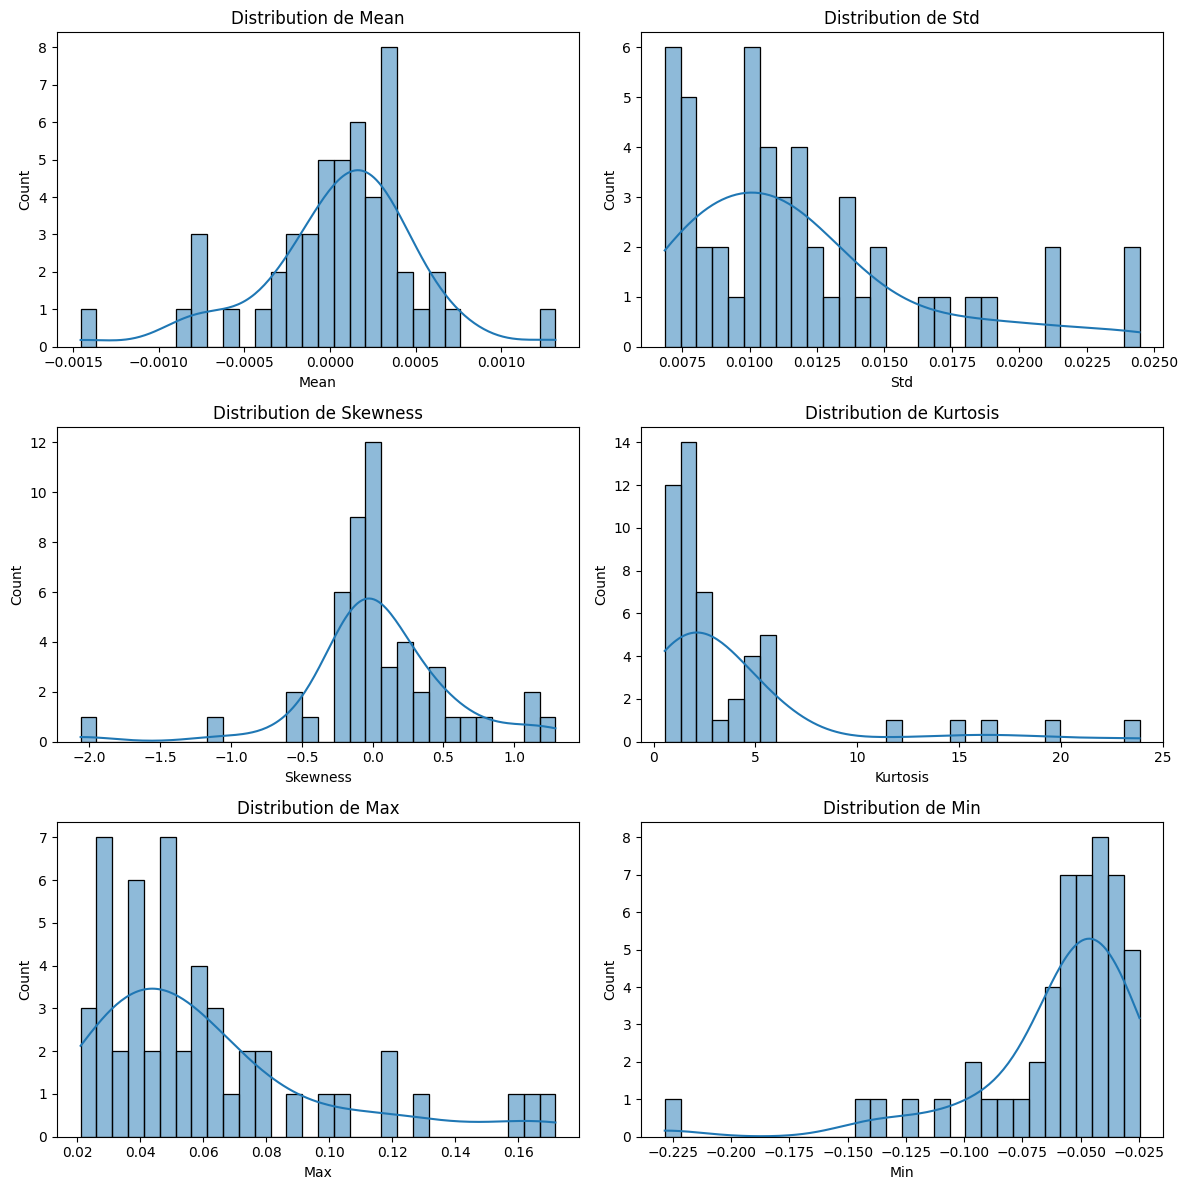

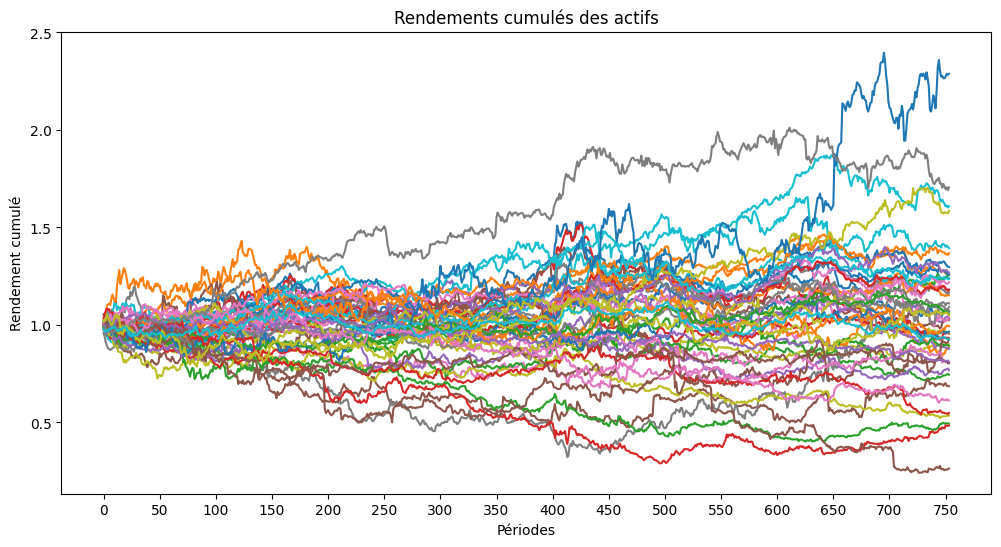

In [5]:
# Analyse statistique des données
stats_df = pd.DataFrame({
    "Mean": X_train.mean(axis=1),
    "Std": X_train.std(axis=1),
    "Skewness": X_train.skew(axis=1),
    "Kurtosis": X_train.kurtosis(axis=1),
    "Max": X_train.max(axis=1),
    "Min": X_train.min(axis=1)
})

print("\nStatistiques des actifs:")
print(stats_df.head())

# Visualisation des distributions des statistiques
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, column in enumerate(stats_df.columns):
    sns.histplot(stats_df[column], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution de {column}")

plt.tight_layout()
plt.show()

# Calcul des rendements cumulés
cumulative_returns = (1 + X_train).cumprod(axis=1)

# Tracé des rendements cumulés
plt.figure(figsize=(12, 6))
for stock in cumulative_returns.index:
    plt.plot(cumulative_returns.columns, cumulative_returns.loc[stock])

plt.xticks(np.arange(0, len(cumulative_returns.columns), step=50))  # Affichage tous les 10 jours
plt.xlabel("Périodes")
plt.ylabel("Rendement cumulé")
plt.title("Rendements cumulés des actifs")
plt.show()

## Méthode de modélisation du Beta et de la métrique d'accuracy (issue du notebook fourni par AQR)

In [6]:
# Reshape des données : reconstruit un nouveau dataframe avec les valeurs de X_train décalées de 1 à 250 jours. Chaque ligne represente un actif et une date, et chaque colonne représente un retard.
#Exemple, pour la première ligne on a l'actif 0 (le 1er) et si tu avances dans les colonnes tu as la valeur t-1, puis t-2 etc...

X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(future_stack=False) for i in range(250) ], axis =1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag') #Renomme les colonnes pour représenter chaque décalage temporel.


# to check the orthonormality constraints as in the metric:
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    #if any(Error.unstack() > 1e-6):
        #bool = False
    max_error = Error.values.max()  # Erreur maximale
    if max_error > 1e-6:
        print(f"⚠️ Problème d'orthonormalité : max error = {max_error:.2e}")
        bool = False
        
    return bool

#Génération des facteurs aléatoires
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return randomStiefel

#Génère un vecteur beta avec m premiers éléments non nuls
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

#Regression lineaire pour ajuster le vecteur beta à partir des facteurs A et des variables cibles Y_train
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack() #Transposition de Y_train et mise sous un format de colonne unique
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    
    return beta.to_numpy()

#Calcul de la métrique
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T #Prédiction avec les facteurs et les beta
    Ytrue = Y_train #Vrai valeurs des rendements
    
    # Normalisation des matrices en divisant chaque valeur par la norme (racine carrée de la somme des carrés).
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean() #Mesure la similarité entre les prédictions et les vraies valeurs en calculant un produit scalaire moyen.


    return  meanOverlap 

## Benchmark

In [7]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = A = randomA()
    beta = fitBeta(A) # A partir des facrtors générés aléatoirement, il va prendre pour chaque point de données, les 250 données précédement formaté a partir de X_reshape et va faire une regression linéaire pour prédire les rendements futurs.
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  


metric_train(A_QRT, beta_QRT) # public metric: 0.03535

print(f"Performance (metric_train): {maxMetric:.5f}")




0 metric_train: 0.02331346933035971
1 metric_train: 0.033196962063374115
3 metric_train: 0.03530204860763571
7 metric_train: 0.03999544914662606
67 metric_train: 0.043593689369261175
138 metric_train: 0.04433262132928291
496 metric_train: 0.04441416345796451
675 metric_train: 0.04578782187329137
Performance (metric_train): 0.04579


# Sélection des features


Nous travaillons sur des rendements financiers et avons sélectionné des features classiques issues de la littérature financière :

- **Momentum** : rendement cumulé sur une fenêtre déterminée, qui mesure la tendance d'un actif.
- **Volatility** : écart-type annualisé des rendements sur une période donnée, indicateur de risque.
- **Moving average** : moyenne mobile des rendements, utile pour lisser les variations et identifier des tendances.
- **RSI (Relative Strength Index)** : indicateur de surachat ou de survente basé sur la force relative des gains et pertes récents.

Nous appliquons une régression : A modifier c'est ce que je faisais au début
1. **Régression individuelle par actif** : chaque actif est modélisé séparément avec ses propres features pour obtenir des coefficients spécifiques.
2. **Régression globale** : les données sont agrégées dans un format long, permettant d'estimer des betas globaux communs à l'ensemble des actifs.

Ces deux approches permettent d’analyser les rendements sous différents angles et de comparer l’efficacité des modèles selon la granularité choisie.


In [8]:

def compute_momentum(returns, window=21):
    """ Calcule le momentum comme rendement cumulé sur la période donnée """
    return returns.rolling(window=window).sum()

def compute_volatility(returns, window=21):
    """ Calcule la volatilité réalisée """
    return returns.rolling(window=window).std()

def compute_moving_average(price, window=21):
    """ Calcule la moyenne mobile """
    ma = price.rolling(window=window).mean()
    return price - ma

def compute_rsi(price, window=14):
    """ Calcule l'indicateur RSI, indicateur de surachat ou de suvente """
    delta = price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() #Moyenne des rendements positifs (gains)
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() #Moyenne des rendement negatifs (pertes)
    rs = gain / loss
    return 100 - (100 / (1 + rs)) #Transformation du rs en score RSI (plus il est important plus c'est un signe de surachat et inversement)

def compute_z_score(series):
    """Calcule le z-score pour chaque série"""
    return (series - series.mean()) / series.std()


def generate_features(X_train):
    """ Génère les features et calcule un facteur unique pour chaque date """
    feature_dict = {}
    
    # Calcul des caractéristiques pour chaque actif
    for col in X_train.columns:
        # Calcul des caractéristiques : momentum, volatilité, moyenne mobile, et RSI
        feature_dict[f'momentum_{col}'] = compute_momentum(X_train[col])
        feature_dict[f'volatility_{col}'] = compute_volatility(X_train[col])
        feature_dict[f'moving_avg_{col}'] = compute_moving_average(X_train[col])
        feature_dict[f'rsi_{col}'] = compute_rsi(X_train[col])

    features = pd.concat(feature_dict, axis=1)  # On concatène tout en une seule fois
    
    # Calcul des z-scores pour chaque caractéristique sur tous les actifs à chaque date
    features_z = features.apply(compute_z_score, axis=0)  # Normalisation

    
    # Maintenant, pour chaque date, on calcule un facteur global (moyenne des z-scores)
    # pour chaque caractéristique
    factor_momentum = features_z.filter(like="momentum").mean(axis=1)  # Moyenne des z-scores du momentum
    factor_volatility = features_z.filter(like="volatility").mean(axis=1)  # Moyenne des z-scores de la volatilité
    factor_moving_avg = features_z.filter(like="moving_avg").mean(axis=1)  # Moyenne des z-scores de la moyenne mobile
    factor_rsi = features_z.filter(like="rsi").mean(axis=1)  # Moyenne des z-scores du RSI

    # DataFrame final avec un facteur pour chaque caractéristique à chaque date
    final_features = pd.DataFrame({
        'momentum_factor': factor_momentum,
        'volatility_factor': factor_volatility,
        'moving_avg_factor': factor_moving_avg,
        'rsi_factor': factor_rsi
    })
    
    # Garde seulement les 250 premières dates
    final_features = final_features.fillna(0)
    final_features = final_features.iloc[:250]
    
    return final_features


def A_Factors(D=250, F=10):
    factors = generate_features(X_train.T).values 

    # Vérification de la correlation entre facteurs pour réaliser l'orthonormalisation
    #corr_matrix = pd.DataFrame(factors).corr() 
    #print(corr_matrix)
    
    # On normalise les 4 facteurs pour qu'ils soient orthonormaux
    A = np.zeros((D, F))
    for i in range(4):
        A[:, i] = factors[:, i] / np.linalg.norm(factors[:, i])

    A[:, :4] = scipy.linalg.orth(A[:, :4]) # Assure l'orthonormalité
    
    if F<=4:
        return A
    
    # # # Génération des 6 autres colonnes orthonormales
    orthoProj = np.eye(D)
    for i in range(4):
        orthoProj -= np.outer(A[:, i], A[:, i])
    
    A_remaining_columns = orthoProj @ np.random.randn(D, F - 4)
    A_remaining_columns = scipy.linalg.orth(A_remaining_columns)  # Orthonormalisation

    A[:, 4:] = A_remaining_columns
    return A

# --- Pipeline principal ---
A = A_Factors()  # Génération de A avec les 4 facteurs définis
beta = fitBeta(A)  # Calcul de beta

# Vérification de la métrique
metric_value = metric_train(A, beta)

# --- Affichage des résultats ---
print(f"Performance (metric_train): {metric_value:.5f}")





#features = generate_features(X_train.T)
#features
#beta = compute_OLS(X_train.iloc[:, :250], Y_train, features)
#beta = fitBeta(features) #La meme regression que pour le benchmark, simplement avec moins de colonne dans features, mais ne fonctionne pas

#long_data = transform_to_long_format(features, X_train)
#betas_global, intercept_global = estimate_global_betas(long_data, long_data[['return']])
#betas_individual, intercepts_individual = estimate_individual_betas(features, X_train)

#m = metric_train(features, beta)




Performance (metric_train): 0.02575


## Modèle non supervisé (clustering)


- Réduction de dimension avec PCA.
- Détermination du meilleur K avec la méthode du coude :
    Analyser l'évolution de l'inertie intra-classe en fonction du nombre de cluster. L'algoritmhe va partionner un ensemble de point en K groupes jusqu'a ce qu'un certain seuil de minimisation de l'inertie intra classe.
    L’inertie diminue forcément quand on augmente 𝐾, mais après un certain point, l'amélioration devient négligeable. Le "coude" est ce point optimal où l'ajout de clusters ne réduit plus significativement l'inertie.




- Application du clustering K-Means.
- Évaluation et ajustement des hyperparamètres (optimisation avec GridSearchCV).

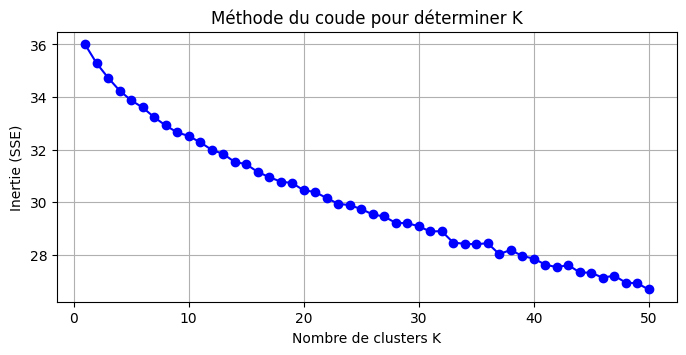

Meilleur modèle K-Means trouvé avec K=26 et init='k-means++'
Performance du modèle : 0.06295


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

def find_optimal_k_elbow(X, max_k=50):
    """Utilise la méthode du coude pour déterminer le nombre optimal de clusters."""
    
    #inertias = [] #Vecteur pour stocker les valeurs d'inertie
    #k_values = range(1, max_k + 1) #Valeurs de K à tester
    
    #Boucle sur les valeurs de K pour calculer l'inertie
    #for k in k_values:
        #kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Exécute KMeans avec K clusters  et 10 initialisations des centroides et choisit la meilleure solution
        #kmeans.fit(X)  # # Entraine le modèle sur les données de X
        #inertias.append(kmeans.inertia_) #Stocke la valeur de l'inertie associé à k

    k_values = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
                    for k in range(1, max_k + 1)]
    inertias = [model.inertia_ for model in k_values] 

    # courbe du coude
    plt.figure(figsize=(8, 3.5))
    plt.plot(range(1, max_k + 1), inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Inertie (SSE)')
    plt.title('Méthode du coude pour déterminer K')
    plt.grid(True)
    plt.show()
    
     # Demande à l'utilisateur de choisir K, en fonction du point optimal sur le graphique, le "coude" ou la courbe commence à s'aplatir
    k_optimal = int(input("Veuillez entrer la valeur optimale de K en fonction du graphique : "))
    return k_optimal
    # plutôt que demander à l'utilisateur, réaliser une règle mathématique

def apply_kmeans(X, k):
    """Applique K-Means et retourne les labels et le modèle KMeans."""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Initialisation du modèle KMeans
    labels = kmeans.fit_predict(X)   #entrainement du modèle et attribution des valeurs à des clusters (labels instances)
    return labels, kmeans

def optimize_clustering(X_train, best_k):
    """Optimise K-Means avec validation croisée manuelle et retourne le meilleur modèle."""
    
    param_grid = {'n_clusters': [best_k-1, best_k, best_k+1], 'init': ['k-means++', 'random']}
    
    best_inertia = np.inf  
    best_model = None  

    # # Validation croisée manuelle avec KFold (3 folds ici, c'est a dire qu'on divise le dataset en 3, pour entrainer sur 2 folds et tester sur la 3eme)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    #Boucle pour parcourir chaque Hyperparamètres
    for n_clusters in param_grid['n_clusters']: #Parcours la liste de nombre de clusters qu'on souhaite tester (best_k-1, best_k, best_k+1)
        for init_method in param_grid['init']:#Parcours la liste des méthodes d'initialisation des centroides ('k-means++', 'random')
            avg_inertia = 0   # Initialisation de la variable d'inertie moyenne pour ces paramètres

            # Boucle sur les splits de la validation croisée
            for train_idx, test_idx in kf.split(X_train):
                X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx] # Sépare les données en train et test
                model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42, n_init=10) #modèle KMeans avec les paramètres de le boucle
                model.fit(X_train_fold)   #Entrainement du modèle sur le jeu d'entrainement
                avg_inertia += model.inertia_   # Évalue l'inertie sur le jeu de test

            avg_inertia /= kf.get_n_splits()   # Moyenne des inerties sur tous les splits

            # Si l'inertie moyenne est meilleure (plus faible), on garde ce modèle
            if avg_inertia < best_inertia:
                best_inertia = avg_inertia
                best_model = model

    print(f"Meilleur modèle K-Means trouvé avec K={best_model.n_clusters} et init='{best_model.init}'")
    return best_model

def generate_factors_from_clusters(X_pca, best_cluster_model):
    """
    Génère la matrice A (250 jours, n_clusters) en utilisant les distances aux centroïdes.
    """
    centroids = best_cluster_model.cluster_centers_  # (n_clusters, d)


    X_pca = np.array(X_pca)  # Assure que c'est bien un tableau NumPy

    # Vérification que les dimensions sont bien alignées
    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilité des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    # Calcul des distances correctement alignées
    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)  

    # Extraction des 250 premières lignes (jours)
    A = distances[:250, :]  # (250, n_clusters)

    A, _ = np.linalg.qr(A)  # Q est une matrice orthonormale

    return A

def compute_OLS(X_train, Y_train,features):
    predictors = X_train @ features
    targets = Y_train.T
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    return beta.to_numpy()

# --- Pipeline principal ---
# 1. Réduction de dimension avec PCA pour X_train.T (taille initiale (50, 754))
pca = PCA(n_components=0.95)  
x_pca = pca.fit_transform(X_train.T)  # Nouvelle taille (754, d)
x_pca, _ = np.linalg.qr(x_pca)

# 2. Trouver K optimal
best_k = find_optimal_k_elbow(x_pca)

# 3. Optimiser K-Means avec validation croisée
best_cluster_model = optimize_clustering(x_pca, best_k)

# 4. Générer la matrice A (250 jours, n_clusters)
A = generate_factors_from_clusters(x_pca, best_cluster_model)

# 5. Effectuer la régression
#beta = compute_OLS(X_train.iloc[:, :250].T, Y_train, A)
#beta = compute_OLS(X_train_reshape, Y_train, A)
beta = fitBeta(A)

# 6. Calculer la métrique de performance
metric_value = metric_train(A, beta)

print(f"Performance du modèle : {metric_value:.5f}")


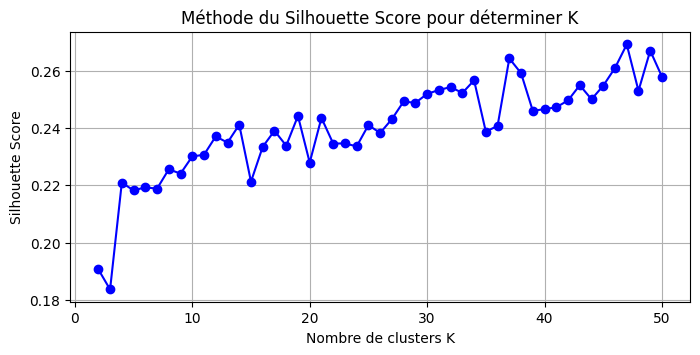

K optimal sélectionné: 47
Performance du modèle : 0.06217


In [10]:
from sklearn.metrics import silhouette_score

def find_optimal_k_silhouette(X, min_k=2, max_k=50):
    """Trouve K optimal avec le Silhouette Score automatiquement, sans input utilisateur."""
    
    best_k = min_k
    best_score = -1  # Le Silhouette Score varie entre -1 et 1, donc on initialise bas
    silhouette_scores = []
    
    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

        if score > best_score:
            best_score = score
            best_k = k

    # Affichage du Silhouette Score pour différents K
    plt.figure(figsize=(8, 3.5))
    plt.plot(range(min_k, max_k + 1), silhouette_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Silhouette Score')
    plt.title('Méthode du Silhouette Score pour déterminer K')
    plt.grid(True)
    plt.show()

    print(f"K optimal sélectionné: {best_k}")
    return best_k

def optimize_clustering(X, best_k):
    """Exécute K-Means avec le K optimal et retourne le modèle entraîné."""
    model = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
    model.fit(X)
    return model

def generate_factors_from_clusters(X, best_cluster_model):
    """
    Génère la matrice de design A en utilisant les appartenances aux clusters.
    Chaque colonne représente un facteur basé sur un cluster.
    """

    labels = best_cluster_model.labels_  # (754,) → Indices des clusters pour chaque action
    n_clusters = best_cluster_model.n_clusters  # Nombre de clusters

    # Création d'une matrice binaire Z (754, n_clusters)
    Z = np.zeros((X.shape[0], n_clusters))  # (Nb d'actions, Nb de clusters)

    for i, label in enumerate(labels):
        Z[i, label] = 1  # Met 1 si l’action appartient à ce cluster

    # Extraction des 250 premières lignes (jours) pour la matrice A
    A = Z[:250, :]  # (250, n_clusters)

    # Orthonormalisation de A
    A, _ = np.linalg.qr(A)

    return A

def compute_OLS(X_train, Y_train, factors):
    """Effectue la régression OLS entre X_train et Y_train avec les facteurs donnés."""
    predictors = X_train @ factors
    targets = Y_train.T
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    return beta.to_numpy()

# --- Pipeline principal ---
# 1. Génération de A (directement en sortie de generate_features)
A = A_Factors(F=4)  # (250, 4)

# 2. Trouver K optimal via le Silhouette Score
best_k = find_optimal_k_silhouette(A)

# 3. Appliquer K-Means
best_cluster_model = optimize_clustering(A, best_k)

# 4. Générer les facteurs à partir des centroïdes et les orthonormaliser
A_clustered = generate_factors_from_clusters(A, best_cluster_model)

# 5. Effectuer la régression
beta = fitBeta(A_clustered)

# 6. Calculer la métrique de performance
metric_value = metric_train(A_clustered, beta)

print(f"Performance du modèle : {metric_value:.5f}")


K optimal trouvé : 2


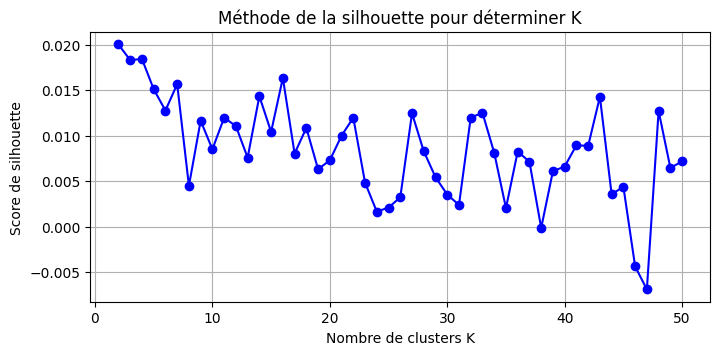

Meilleur modèle K-Means trouvé avec K=3 et init='k-means++'
Performance du modèle : 0.02670


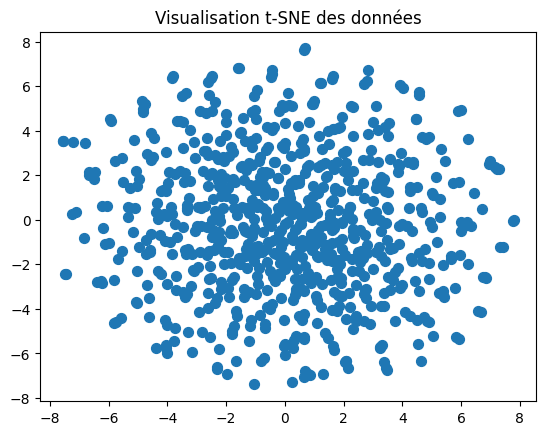

Inertie intra-cluster : 35.28629509325721
Distance entre les centroïdes : 0.06214959191286626
Labels des clusters : [0 0 2 1 0 0 2 3 0 4 2 4 2 1 4 4 4 4 1 0 1 2 3 3 4 1 2 3 3 4 3 3 0 0 3 4 1
 1 2 3 1 1 2 1 1 0 3 1 0 2 4 0 0 3 1 4 0 1 0 0 4 0 3 2 0 0 3 3 3 2 0 2 3 4
 4 1 3 4 0 0 0 2 4 3 1 1 4 0 0 3 4 3 3 1 4 1 4 3 1 3 0 2 0 0 0 1 0 0 3 3 3
 1 2 0 0 3 2 1 4 0 3 2 1 3 2 3 0 2 0 2 0 4 1 4 2 2 3 4 0 3 4 0 1 3 3 1 0 0
 0 1 0 0 4 1 2 0 3 3 4 0 4 3 3 2 2 4 1 0 1 0 0 2 0 3 2 0 3 1 2 3 3 1 2 2 3
 3 4 3 1 2 0 0 4 1 1 4 2 2 3 0 2 0 3 0 3 0 2 0 3 1 3 4 3 1 1 2 1 1 1 0 0 2
 3 0 2 1 4 2 3 1 3 3 1 3 4 0 0 0 2 3 3 2 2 4 4 4 0 4 0 2 3 0 1 0 1 2 2 3 3
 1 0 2 4 2 3 0 3 3 4 1 4 1 0 4 0 3 1 1 1 2 0 4 1 2 3 2 0 4 2 2 1 1 2 0 3 0
 0 0 2 4 4 3 4 4 3 1 3 3 3 1 3 0 4 3 0 4 1 2 1 3 4 0 2 2 2 1 4 1 0 4 3 0 0
 3 0 0 0 4 0 1 1 1 2 1 3 0 4 0 2 3 1 4 1 4 3 1 1 4 2 4 1 0 1 3 3 2 2 2 2 2
 1 1 2 1 1 1 4 0 1 0 3 2 4 1 3 1 4 4 4 1 0 4 2 4 2 3 4 1 4 0 4 0 3 4 1 3 4
 0 3 0 0 0 3 2 0 1 4 1 3 4 1 1 4 4 4 1 4 0 2 0 0 2 0 1 2 0 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score

def find_optimal_k(X, max_k=50):
    """Détermine le nombre optimal de clusters en utilisant la méthode de la silhouette."""
    silhouette_scores = []
    k_values = range(2, max_k + 1)  # La silhouette nécessite au moins 2 clusters

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))

    # Trouver le K optimal (maximiser la silhouette)
    best_k = k_values[np.argmax(silhouette_scores)]
    print(f"K optimal trouvé : {best_k}")

    # Tracer la courbe de la silhouette
    plt.figure(figsize=(8, 3.5))
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Score de silhouette')
    plt.title('Méthode de la silhouette pour déterminer K')
    plt.grid(True)
    plt.show()

    return best_k

def optimize_clustering(X_train, best_k):
    """Optimise K-Means avec validation croisée manuelle et retourne le meilleur modèle."""
    param_grid = {'n_clusters': [best_k-1, best_k, best_k+1], 'init': ['k-means++', 'random']}
    best_inertia = np.inf
    best_model = None

    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    for n_clusters in param_grid['n_clusters']:
        for init_method in param_grid['init']:
            avg_inertia = 0

            for train_idx, test_idx in kf.split(X_train):
                X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
                model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42, n_init=10)
                model.fit(X_train_fold)
                avg_inertia += model.inertia_

            avg_inertia /= kf.get_n_splits()

            if avg_inertia < best_inertia:
                best_inertia = avg_inertia
                best_model = model

    print(f"Meilleur modèle K-Means trouvé avec K={best_model.n_clusters} et init='{best_model.init}'")
    return best_model

def generate_factors_from_clusters(X_pca, best_cluster_model):
    """Génère la matrice A (250 jours, n_clusters) en utilisant les distances aux centroïdes."""
    centroids = best_cluster_model.cluster_centers_
    X_pca = np.array(X_pca)

    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilité des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    A = distances[:250, :]
    A, _ = np.linalg.qr(A)  # Orthonormalisation

    return A

# --- Pipeline principal ---
# 1. Réduction de dimension avec PCA
pca = PCA(n_components=0.95)
x_pca = pca.fit_transform(X_train.T)
x_pca, _ = np.linalg.qr(x_pca)

# 2. Trouver K optimal avec la méthode de la silhouette
best_k = find_optimal_k(x_pca)

# 3. Optimiser K-Means avec validation croisée
best_cluster_model = optimize_clustering(x_pca, best_k)

# 4. Générer la matrice A (250 jours, n_clusters)
A = generate_factors_from_clusters(x_pca, best_cluster_model)

# 5. Effectuer la régression
beta = fitBeta(A)

# 6. Calculer la métrique de performance
metric_value = metric_train(A, beta)

print(f"Performance du modèle : {metric_value:.5f}")